# HW 28

In [15]:
import jax
import jax.numpy as jnp
# import numpy as np
import pandas as pd
# import PIL
import scipy
# import sympy as sp
from matplotlib import pyplot as plt
from scipy.optimize import minimize

<img src="fig_28_intro.png" alt="formula" width="900">

In [2]:
data = pd.read_csv("enso.txt", sep=r'\s+', header=None).values
t = data[:, 1] # months
y = data[:, 0] # atmospheric pressure

In [3]:
def f(t: jnp.ndarray, th1: float, th2: float, th3: float, th4: float, th5: float, th6: float, th7: float, th8: float, th9: float) -> jnp.ndarray:
    out = jnp.array(
        [
            jnp.full(t.shape, th1)+
            th2*jnp.cos(2*jnp.pi*t*(1/12))+   # annual cycle
            th3*jnp.sin(2*jnp.pi*t*(1/12))+   # annual cycle
            th5*jnp.cos(2*jnp.pi*t*(1/th4))+  # el nino
            th6*jnp.sin(2*jnp.pi*t*(1/th4))+  # el nino
            th8*jnp.cos(2*jnp.pi*t*(1/th7))+  # southern oscillation
            th9*jnp.sin(2*jnp.pi*t*(1/th7))   # southern oscillation
        ]
    ).T
    return out

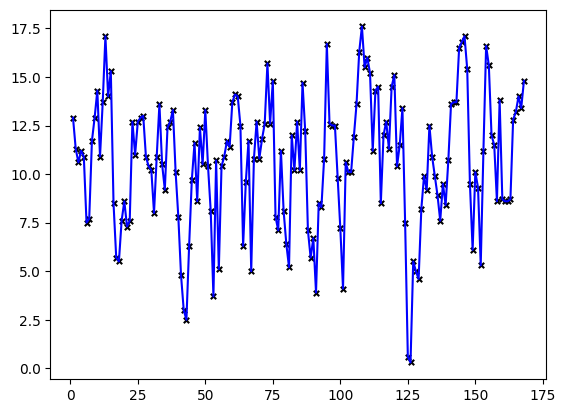

In [4]:
# let's plot data for an initial visualization
plt.scatter(t, y, color="black", marker="x", s=15)
plt.plot(t, y, color="blue")

<img src="fig_28_a.png" alt="formula" width="900">

In [5]:
# Theta_0 should correspond the the average of the average atmospheric pressure because it shifts the
# whole distribution of outcomes equally.

th1_init = jnp.mean(y) # near 10.6

<img src="fig_28_b.png" alt="formula" width="900">

In [6]:
# The parameters applied outside the sin/cosine functions listed in (b) must correspond to the variation in signal
# attributable to effects of time because they are associated with fluctuations from the mean associated with a
# certain wavelength.

# Based on this, and in considering the plot above, I recommend:
th2_init = jnp.float64(7) # annual fluctuation, could be 6-8
th3_init = jnp.float64(7) # annual fluctuation, could be 6-8
th5_init = jnp.float64(5) # notable fluctuation near month 125, could be 4-6
th6_init = jnp.float64(5) # notable fluctuation near month 125, could be 4-6
th8_init = jnp.float64(5) # general fluctuation over multiple years, as in month 0-75, could be 4-6
th9_init = jnp.float64(5) # general fluctuation over multiple years, as in month 0-75, could be 4-6

/Users/wesley/GitHub/BYU/cs-580-misc/.venv/lib/python3.13/site-packages/jax/_src/numpy/scalar_types.py:50: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


<img src="fig_28_c.png" alt="formula" width="900">

In [7]:
# The parameters associated with periods listed in (c) would correspond to the period of the other two
# signals in the data: the fluctuation near month 125 is transient, so it should have a long wavelength
# to prevent it from causing noise in other time points. Conversely, the multi-year oscillation most
# notable in months 0-75 should have an associated wavelength

# the longest and shortest periods I would consider reasonable would be:
# (longest) 2*len(t) -- referring to a signal that has 1/2 its wavelength in the range of the data
# (shortest) 5 -- referring to transient but repeated signal in the data

# Based on this, and in considering the plot above, I recommend:
th4_init = jnp.float64(125*2) # transient fluctuation near month 125, could be 125-2*len(t)
th7_init = jnp.float64(75) # multi-year fluctuation, could be 50-100

In [8]:
# combining all our theta values gives:
theta_init = jnp.array([th1_init, th2_init, th3_init, th4_init, th5_init, th6_init, th7_init, th8_init, th9_init])

# we could also make up some bad guesses for use in (d)
bad_thetas = jnp.array([30, 20, 20, 20, 20, 20, 20, 10, 1], dtype=jnp.float32)

<img src="fig_28_d.png" alt="formula" width="900">

In [9]:
partial_th4 = jax.jacrev(f, argnums=4)
partial_th7 = jax.jacrev(f, argnums=7)

normed_deriv_4 = jnp.linalg.norm(partial_th4(t, *theta_init), ord=2)
print(f"The norm of df/dth4 for good thetas is {normed_deriv_4}")

normed_deriv_7 = jnp.linalg.norm(partial_th7(t, *theta_init), ord=2)
print(f"The norm of df/dth7 for good thetas is {normed_deriv_7}")

normed_deriv_4_bad = jnp.linalg.norm(partial_th4(t, *bad_thetas), ord=2)
print(f"The norm of df/dth4 for bad thetas is {normed_deriv_4_bad}")

normed_deriv_7_bad = jnp.linalg.norm(partial_th7(t, *bad_thetas), ord=2)
print(f"The norm of df/dth7 for bad thetas is {normed_deriv_7_bad}")

The norm of df/dth4 for good thetas is 0.5470356345176697
The norm of df/dth7 for good thetas is 6.668302536010742
The norm of df/dth4 for bad thetas is 400.1517028808594
The norm of df/dth7 for bad thetas is 142.78128051757812


In [10]:
# I observe that the normed gradients are much greater for bad/extreme values
# of the parameters. This suggests that the cost surface is very steep at those
# locations in parameter space, which is intuitive given that the parameters
# are so far from being reasonable

<img src="fig_28_e.png" alt="formula" width="900">

In [19]:
def c(thet):
    y_hat = f(t, *thet)
    diff = y_hat-y
    cost = 0.5*jnp.linalg.norm(diff)**2
    return cost

In [22]:
theta_best = minimize(c, theta_init)

In [21]:
theta_best.x

array([ 10.641668,   7.      ,   7.      , 250.      ,   5.      ,
         5.      ,  75.      ,   5.      ,   5.      ], dtype=float32)

<img src="fig_28_f.png" alt="formula" width="900">

# CHAT: TODO

In [ ]:
raise NotImplementedError("Need chat link")

# Acknowledgment
Work in this repository and with associated assignments and projects may be adapted or copied from similar files used in my prior academic and industry work (e.g., using a LaTeX file or Dockerfile as a starting point). Those files and any other work in this repository may have been developed with the help of LLM's like ChatGPT. For example, to provide context, answer questions, refine writing, understand function call syntax, and assist with repetitive tasks. In these cases, deliverables and associated work reflect my best efforts to optimize my learning and demonstrate my capacity, while using available resources and LLM's to facilitate the process.


[ChatGPT Conversation](https://chatgpt.com)